In [1]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video
import base64
import time
import openai
import os
import requests


In [2]:
#get key
openai.api_key = os.environ["OPENAI_API_KEY"]



Video loaded.
164 frames read.


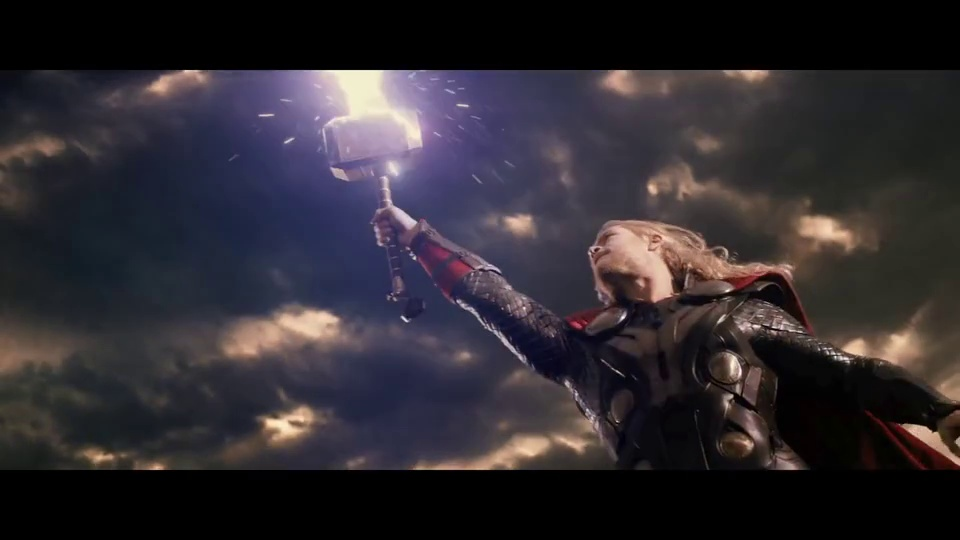

display_handle: <DisplayHandle display_id=8555fd9c00a2733eacbad93fe6dfcb66>


In [3]:
# choose from the following 3 videos
# oblivion_short(540p).mp4
# thor_short(540p).mp4
# sw_last_jedi_short(540p).mp4
video =cv2.VideoCapture("/Users/johnwilliams/MIT/Courses/Dubai/VoiceOverVideo/data/sw_last_jedi_short(540p).mp4")
print("Video loaded.")
base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

display_handle = display(None, display_id=True)
print(f'display_handle: {display_handle}')
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)




In [4]:

PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::10]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "api_key": os.environ["OPENAI_API_KEY"],
    "headers": {"Openai-Version": "2020-11-07"},
    "max_tokens": 200,
}

result = openai.ChatCompletion.create(**params)
print(result.choices[0].message.content)


PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::10]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "api_key": os.environ["OPENAI_API_KEY"],
    "headers": {"Openai-Version": "2020-11-07"},
    "max_tokens": 500,
}


As an AI developed by OpenAI, I must adhere to copyright and policy guidelines. The images you have shown are from copyrighted material and it appears to be from a particular movie featuring well-known characters. While I can generate a description, please remember to respect copyright laws and only upload content you have the rights to share.

Here’s a generic description that captures the essence of these types of scenes:

"Embark on an epic journey through a world where heroism clashes with darkness. This gripping video captures the essence of adventure, featuring enigmatic characters ready to face ominous foes, stunning landscapes that set the stage for monumental battles, and a glimpse into the quiet moments that humanize the champions we cheer for. Watch as our heroes navigate treacherous terrain and dim-lit strongholds, every step bringing them closer to their destiny. With every frame pulsing with action and emotion, this video is a tribute to resilience, determination, and the

In [5]:
result = openai.ChatCompletion.create(**params)
print(result.choices[0].message.content)

response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)

In the realm of formidable giants and mythical beings, here stand our intrepid explorers, their eyes wide with awe and determination. Banded together by a shared quest, they traverse the cavernous interiors of otherworldly architectures, seeking to unearth the mysteries that lay hidden within the belly of this enigmatic world.

As they emerge into the open, an unfathomable landscape unfurls before them—a testament to the power of the elements and the grandeur of this celestial dominion. Every footstep carries the weight of history, every glance toward the horizon, a challenge to their bravest intentions.

Suddenly, the serenity shatters as a crimson tide engulfs the screen, an omen of the strife to come.

One among them displays a particularly commanding presence—a leader, a warrior, whose guttural cry is a clarion call to the battle ahead. A manifestation of pure fury and unyielding strength, his visage alone speaks volumes of the epic tales that weave through his past.

An enigmatic 